## Функциональный APi.
 Достаточно часто, мы хотим строить модели более сложные, чем просто линейный набор слоев. Или хотим добавить какой-то трюк, наподобие прокидывание данных на какой-то из слоев модели (как ResNet архитектура от майкрософт). В таком случае нам на помощь приходит функциональный api от keras. Он позволяет придумывать и реализовывать код как угодно.

## 7.1.1. Введение в функциональный api

In [1]:
import keras
import tensorflow as tf
from keras import Input, layers 
input_tensor = Input(shape=(32,))
dense = layers.Dense(32, activation='relu')
output_tensor = dense(input_tensor)

C:\Users\vvsol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Начнем с маленького примера, который описывает как обычную модель можно представить в ввиде api.

In [2]:
from keras.models import Sequential, Model 
from keras import layers 
from keras import Input 

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,))) 
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

In [3]:
# нужно для винды, если не видит путь до graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


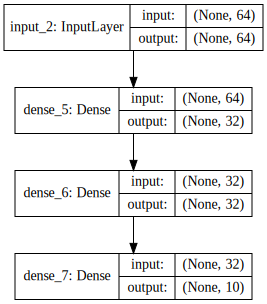

In [4]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Единственная часть, которая может показаться немного волшебной в этой точке, - создание экземпляра объекта Model с использованием только входного и выходного тензоров. За кулисами Keras извлекает все слои, участвующие в переходе от input_tensor к output_tensor, объединяя их в графоподобную структуру данных - модель. Конечно, причина этого в том, что output_tensor был получен путем многократного преобразования input_tensor. Если вы попытались построить модель из входных и выходных данных, которые не были связаны, вы получите RuntimeError:

In [5]:
# unrelated_input = Input(shape=(32,))
# bad_model = Model(unrelated_input, output_tensor)

Ошибка говорит нам о том, что керас не смог достичь output преобразовывая input.

все остальное работает как в стандартной модели, обучение и применение.

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10)) 

model.fit(x_train, y_train, epochs=10, batch_size=128)

score = model.evaluate(x_train, y_train)

Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 11.6652
Epoch 2/10
1000/1000 [==============================] - 0s 37us/step - loss: 11.5269
Epoch 3/10
1000/1000 [==============================] - 0s 34us/step - loss: 11.5068
Epoch 4/10
1000/1000 [==============================] - 0s 31us/step - loss: 11.4964
Epoch 5/10
1000/1000 [==============================] - 0s 33us/step - loss: 11.4909
Epoch 6/10
1000/1000 [==============================] - 0s 29us/step - loss: 11.4867
Epoch 7/10
1000/1000 [==============================] - 0s 32us/step - loss: 11.4841
Epoch 8/10
1000/1000 [==============================] - 0s 29us/step - loss: 11.4815
Epoch 9/10
1000/1000 [==============================] - 0s 30us/step - loss: 11.4789
Epoch 10/10
1000/1000 [==============================] - 0s 47us/step



### 7.1.2 Модели с несколькими входами

Функциональный API может использоваться для построения моделей с несколькими входами. Как правило, такие модели в какой-то момент объединяют свои различные входные ветви, используя слой, который может объединять несколько тензоров: добавляя их, объединяя их и так далее. Обычно это делается с помощью операции слияния Keras, такой как keras.layers.add, keras.layers.concatenate и так далее.

#### Пример модели с ответом на вопрос
Давайте рассмотрим очень простой пример модели с несколькими входами: модель с ответом на вопрос. Типичная модель ответа на вопрос имеет два входа: вопрос на естественном языке и текстовый фрагмент (такой как новостная статья), предоставляющий информацию, которая будет использоваться для ответа на вопрос. Затем модель должна дать ответ: в простейшей возможной настройке это ответ из одного слова, полученный с помощью softmax по некоторой предопределенной лексике.

Ниже приведен пример того, как вы можете построить такую модель с помощью функционального API. Вы устанавливаете две независимые ветви, кодирующие ввод текста и ввод вопроса в качестве векторов представления; затем объединить эти векторы; и, наконец, добавьте классификатор softmax поверх составных представлений.

#### Функциональная реализация API модели ответа на два вопроса

In [7]:
from keras.models import Model
from keras import layers
from keras import Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# Ввод текста представляет собой последовательность целых чисел переменной длины.
# Обратите внимание, что вы можете по желанию назвать входы
text_input = Input(shape=(None,), dtype='int32', name='text')
embedded_text = layers.Embedding(text_vocabulary_size,64)(text_input)
# С помощью LSTM переводим текст в последовательность
encoded_text = layers.LSTM(32)(embedded_text)
# Тот же процесс (с разными экземплярами слоя) для вопроса
question_input = Input(shape=(None,),dtype='int32',name='question')
embedded_question = layers.Embedding(question_vocabulary_size,32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question) 
# Соеденяем вопрос и тестк
concatenated = layers.concatenate([encoded_text, encoded_question],axis=-1)
# Добавляем softmax итоговый
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)
# Модельс 2мя входами и 1 выходом, поэтому задаем таким образом
model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 32)     320000      question[0][0]                   
__________________________________________________________________________________________________
lstm_1 (LS

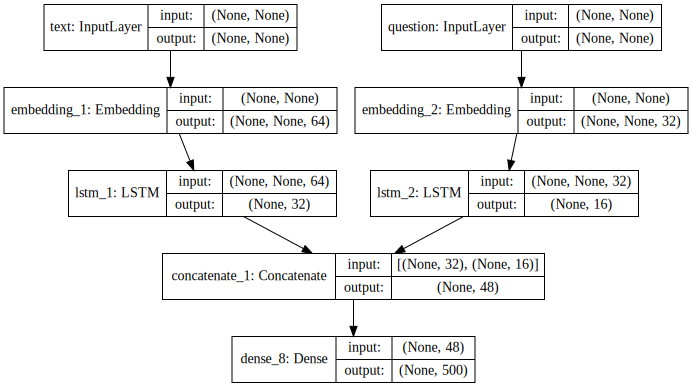

In [8]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Теперь, как вы тренируете эту модель с двумя входами? Существует два возможных API: вы можете передать модели список массивов Numpy в качестве входных данных, или вы можете передать ему словарь, который отображает входные имена в массивы Numpy. Естественно, последний вариант доступен только в том случае, если вы даете имена своим входам.

#### Обучение модели с несколькими входами

In [9]:
import numpy as np
num_samples = 1000 
max_length = 100

# создаем данные
text = np.random.randint(1, text_vocabulary_size,size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size,size=(num_samples, max_length)) 
# ответ у нас должен быть one-hot, не число
answers = np.random.randint(answer_vocabulary_size, size=(num_samples))
answers = keras.utils.to_categorical(answers, answer_vocabulary_size)

# Фиттим модеь с листом input
print('-'*10,"First training run with list of NumPy arrays",'-'*60)
model.fit([text, question], answers, epochs=10, batch_size=128)
print()

# тоже самое, но со словарем
print('-'*10,"Second training run with dictionary and named inputs",'-'*60)
model.fit({'text': text, 'question': question}, answers,epochs=10, batch_size=128)

---------- First training run with list of NumPy arrays ------------------------------------------------------------
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 6.2149 - acc: 0.0020
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 6.1999 - acc: 0.0280
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 6.1625 - acc: 0.0080
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 6.0812 - acc: 0.0050
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 6.0248 - acc: 0.0050
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 5.9652 - acc: 0.0110
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 5.9003 - acc: 0.0130
Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - loss: 5.8058 - acc: 0.0110
Epoch 9/10
1000/1000 [==============================] - 2s 2ms/step - loss: 5.6997 - acc: 0.0160
Epoch 10/1


### 7.1.3 Модели с несколькими выходами
Вы также можете использовать функциональный API для построения моделей с несколькими выходами (или несколькими головками).

#### Пример - прогноз возраста, пола и дохода от постов в социальных сетях
Простым примером является сеть, которая пытается одновременно предсказать различные свойства данных, например, сеть, которая принимает в качестве входных данных серию сообщений в социальных сетях от одного анонимного человека и пытается предсказать атрибуты этого человека, такие как возраст, пол и уровень дохода.

#### Реализация функциональной API модели прогнозирования с тремя выходами

In [10]:
from keras import layers
from keras import Input 
from keras.models import Model 

vocabulary_size = 50000 
num_income_groups = 10 

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size,256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu', padding='same')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x) 
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x) 

# Заметим, что выходным лаерам лучше дать имя.
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups, activation='softmax',name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)
model = Model(posts_input,[age_prediction, income_prediction, gender_prediction])

print("Model is ready!")

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Model is ready!



Важно отметить, что для обучения такой модели требуется способность задавать разные функции потерь для разных руководителей сети: например, прогнозирование возраста является задачей скалярной регрессии, но прогнозирование пола является задачей бинарной классификации, требующей другой процедуры обучения. Но поскольку для градиентного спуска требуется минимизировать скаляр, мы должны объединить эти потери в одно значение, чтобы обучить модель. Самый простой способ объединить разные потери - это сложить их все. В Keras вы можете использовать список или словарь потерь при компиляции, чтобы указать разные объекты для разных выходных данных; полученные значения потерь суммируются в общую потерю, которая минимизируется во время обучения.

#### Опции компиляции модели с несколькими выходами: множественные потери

In [11]:
model.compile(optimizer='rmsprop', loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',loss={'age': 'mse',
                                        'income': 'categorical_crossentropy',
                                        'gender': 'binary_crossentropy'})

#### Проблема с несбалансированными потерями

Обратите внимание, что очень несбалансированные вклады в потери приведут к тому, что представления модели будут оптимизированы преимущественно для задачи с наибольшими индивидуальными потерями за счет других задач. Чтобы исправить это, вы можете назначить разные уровни важности значениям потерь в их вкладе в окончательные потери. Это полезно, в частности, если значения потерь используют разные шкалы.

Например, потеря среднего квадрата ошибки (MSE), используемая для задачи возрастной регрессии, обычно принимает значение около 3–5, тогда как потеря кросс-энтропии, используемая для задачи классификации по полу, может составлять всего 0,1. В такой ситуации, чтобы уравновесить вклад различных потерь, вы можете назначить вес 10 для потери кроссентропии и вес 0,25 для потери MSE.

#### Решение проблемы несбалансированных потерь

In [12]:
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10.]) 

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',
              loss={'age': 'mse','income': 'categorical_crossentropy','gender': 'binary_crossentropy'},
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 128)    163968      embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, None, 128)    0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (

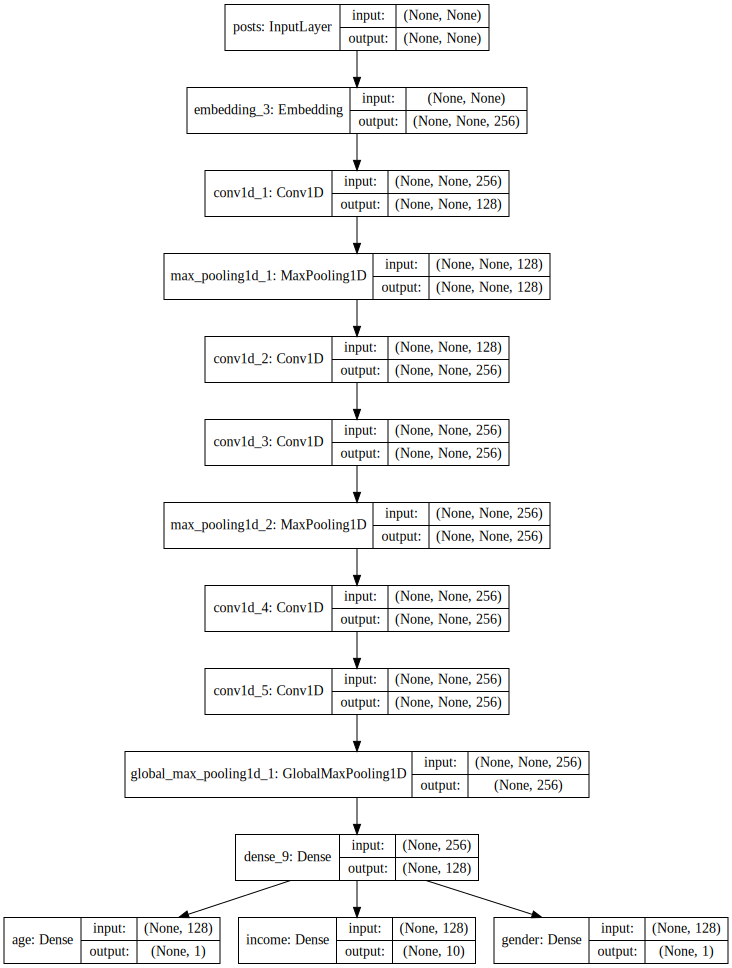

In [13]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

#### Подача данных в модель с несколькими выходами

Как и в случае моделей с несколькими входами, вы можете передавать данные Numpy в модель для обучения либо через список массивов, либо через словарь массивов.
#### Обучение модели с несколькими выходами

In [14]:
import numpy as np 

TRACE = False

num_samples = 1000 
max_length = 100 

posts = np.random.randint(1, vocabulary_size, size=(num_samples, max_length))
if TRACE:
    print("*** POSTS ***")
    print(posts.shape)
    print(posts[:10])
    print()

age_targets = np.random.randint(0, 100, size=(num_samples,1))
if TRACE:
    print("*** AGE ***")
    print(age_targets.shape)
    print(age_targets[:10])
    print()

income_targets = np.random.randint(1, num_income_groups, size=(num_samples,1))
income_targets = keras.utils.to_categorical(income_targets,num_income_groups)
if TRACE:
    print("*** INCOME ***")
    print(income_targets.shape)
    print(income_targets[:10])
    print()

gender_targets = np.random.randint(0, 2, size=(num_samples,1))
if TRACE:
    print("*** GENDER ***")
    print(gender_targets.shape)
    print(gender_targets[:10])
    print()

print('-'*10, "First training run with NumPy arrays", '-'*60)
# age_targets, income_targets, and gender_targets are assumed to be Numpy arrays.
model.fit(posts, [age_targets, income_targets, gender_targets], epochs=10, batch_size=64)

print('-'*10,"Second training run with dictionary and named outputs",'-'*60)
# Equivalent (possible only if you give names to the output layers)
model.fit(posts, {'age': age_targets,
                  'income': income_targets,
                  'gender': gender_targets},
          epochs=10, batch_size=64)

---------- First training run with NumPy arrays ------------------------------------------------------------
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 509.2666 - age_loss: 1924.5327 - income_loss: 3.2926 - gender_loss: 2.4841
Epoch 2/10
1000/1000 [==============================] - 0s 376us/step - loss: 157.1415 - age_loss: 583.1616 - income_loss: 2.2809 - gender_loss: 0.9070
Epoch 3/10
1000/1000 [==============================] - 0s 380us/step - loss: 115.2965 - age_loss: 412.8247 - income_loss: 2.3366 - gender_loss: 0.9754
Epoch 4/10
1000/1000 [==============================] - 0s 371us/step - loss: 142.8738 - age_loss: 531.3946 - income_loss: 2.3023 - gender_loss: 0.7723
Epoch 5/10
1000/1000 [==============================] - 0s 373us/step - loss: 115.3986 - age_loss: 417.2190 - income_loss: 2.3172 - gender_loss: 0.8777
Epoch 6/10
1000/1000 [==============================] - 0s 375us/step - loss: 92.0746 - age_loss: 320.9345 - income_loss: 2.2721 - g

### 7.1.4 Направленные ациклические графы слоев

С помощью функционального API вы можете не только создавать модели с несколькими входами и выходами, но и реализовывать сети со сложной внутренней топологией. Нейронные сети в Керасе могут быть произвольно ориентированными ациклическими графами слоев. Квалификатор acyclic важен: у этих графиков не может быть циклов. Тензор <strong> x </strong> не может стать входом одного из слоев, которые сгенерировали <strong> x </strong>. Разрешены только те циклы обработки (то есть повторяющиеся соединения), которые являются внутренними по отношению к повторяющимся уровням.

Несколько общих компонентов нейронной сети реализованы в виде графиков. Двумя известными из них являются <i> начальные модули </i> и <i> остаточные соединения </i>. Чтобы лучше понять, как функциональный API можно использовать для построения графиков слоев, давайте посмотрим, как вы можете реализовать их оба в Keras.


#### Inception модули

Inception [3] является популярным типом сетевой архитектуры для сверточных нейронных сетей. Он состоит из стека модулей, которые выглядят как небольшие независимые сети, разделенные на несколько параллельных ветвей.

##### Цель 1 × 1 сверток

Свертки 1 × 1 (также называемые точечными свертками) представлены в начальных модулях, где они вносят вклад в факторизованное изучение каналов и изучение пространственных объектов.
 

In [15]:
from keras import layers 
from keras.layers import Input

# Этот пример ожидаем 4д тензор
# Возвращаем тензор, который ожидаем для MNIST
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Branch_a
branch_a = layers.Conv2D(128, 1, padding='same', activation='relu', strides=2)(x)

# Branch_b
branch_b = layers.Conv2D(128, 1, padding='same', activation='relu')(x)
branch_b = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_b)

# делаем средний пулинг
branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
branch_c = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)

# Соеденяем нашу прелесть
output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

# Ну и классификатор наверх
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

model = keras.models.Model(inputs=x, outputs=predictions)

x.shape: (?, 28, 28, 1)


#### Обучаем  Inception model на MNIST 

Взято отсюда: https://github.com/keras-team/keras/blob/master/examples/mnist_dataset_api.py

In [16]:
import numpy as np
import os
import tempfile

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist

import tensorflow as tf

if K.backend() != 'tensorflow':
    raise RuntimeError('This example can only run with the TensorFlow backend,'
                       ' because it requires the Dataset API, which is not'
                       ' supported on other platforms.')

batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 5
num_classes = 10

def cnn_layers(x):
    

    print("x.shape:",x.shape)


    branch_a = layers.Conv2D(128, 1, padding='same', activation='relu', strides=2)(x)
    branch_b = layers.Conv2D(128, 1, padding='same', activation='relu')(x)
    branch_b = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_b)
    branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
    branch_c = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_c)
    branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
    branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
    branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)
    output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)
    output = layers.Flatten()(output)
    output = layers.Dense(512, activation='relu')(output)
    predictions = layers.Dense(num_classes, activation='softmax')(output)
    
    return predictions

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_train = np.expand_dims(x_train, -1)
y_train = tf.one_hot(y_train, num_classes)

# Create the dataset and its associated one-shot iterator.
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()

# Используем итератор, так как нам вернули генератор картинок
inputs, targets = iterator.get_next()

print("inputs.shape:",inputs.shape)
print("targets.shape:",targets.shape)

model_input = layers.Input(tensor=inputs)
model_output = cnn_layers(model_input)

model = keras.models.Model(inputs=model_input, outputs=model_output)

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              target_tensors=[targets])

inputs.shape: (?, 28, 28, 1)
targets.shape: (?, 10)
x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 28, 28, 128)  256         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 128)  256         input_3[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 14, 14, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_13 

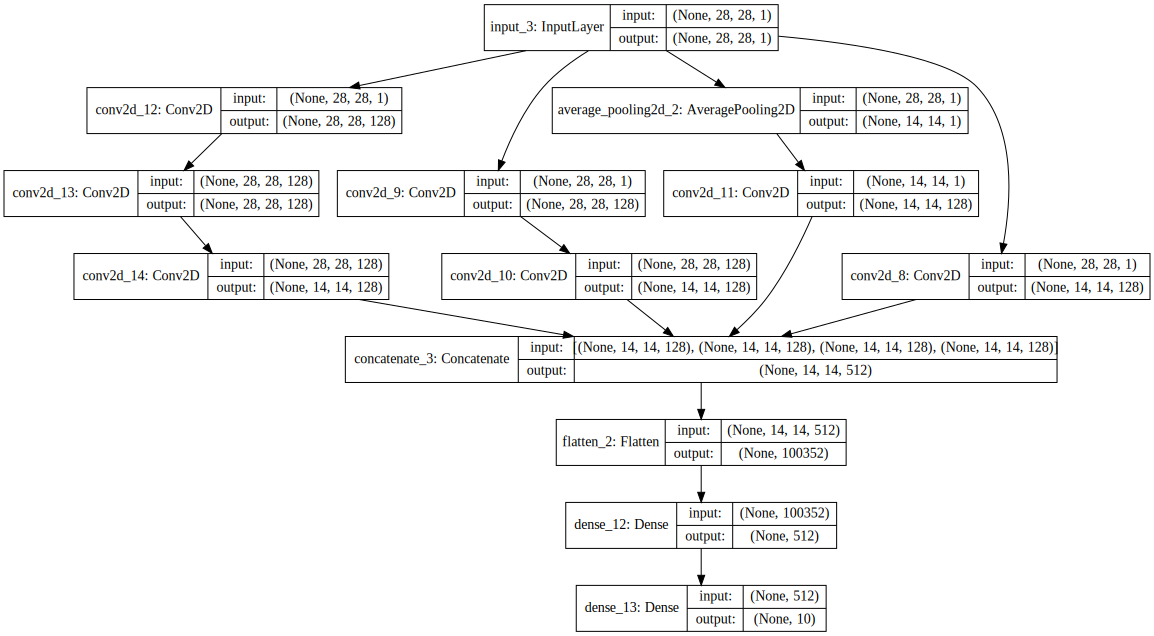

In [17]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

#### Обучаем Inception model

In [18]:
model.fit(epochs=epochs,
          steps_per_epoch=steps_per_epoch)

# Сохраняем веса
weight_path = os.path.join(tempfile.gettempdir(), 'saved_Inception_wt.h5')
model.save_weights(weight_path)

Epoch 1/5
469/469 [==============================] - 67s 143ms/step - loss: 0.1939 - acc: 0.9539
Epoch 2/5
469/469 [==============================] - 56s 120ms/step - loss: 0.0405 - acc: 0.9872
Epoch 3/5
469/469 [==============================] - 56s 120ms/step - loss: 0.0245 - acc: 0.9927
Epoch 4/5
469/469 [==============================] - 57s 121ms/step - loss: 0.0134 - acc: 0.9959
Epoch 5/5
469/469 [==============================] - 56s 120ms/step - loss: 0.0104 - acc: 0.9970


#### Тестим the Inception model

Теперь возьмем и посмотрим, что же у нас получилось

In [19]:
# Чистим нашу сессию
K.clear_session()


x_test = x_test.astype(np.float32)
x_test = np.expand_dims(x_test, -1)

x_test_inp = layers.Input(shape=x_test.shape[1:])
test_out = cnn_layers(x_test_inp)
test_model = keras.models.Model(inputs=x_test_inp, outputs=test_out)

weight_path = os.path.join(tempfile.gettempdir(), 'saved_Inception_wt.h5')
test_model.load_weights(weight_path)

test_model.compile(optimizer='rmsprop',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
test_model.summary()

SVG(model_to_dot(test_model).create(prog='dot', format='svg'))

loss, acc = test_model.evaluate(x_test, y_test, num_classes)
print('\nTest accuracy: {0}'.format(acc))

x.shape: (?, 28, 28, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 128)  256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  256         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 14, 14, 1)    0           input_1[0][0]                    
_____________________________________________________________________________________


#### Остаточные соединения - ResNET

Остаточные соединения или ResNET являются распространенным графоподобным сетевым компонентом, который встречается во многих сетевых архитектурах после 2015 года, включая Xception. Они были представлены He et al. от Microsoft и решают две общие проблемы с крупномасштабной моделью глубокого обучения: исчезающие градиенты и узкие места представления.

Остаточное соединение состоит в том, чтобы сделать выход более раннего уровня доступным в качестве входных данных для более позднего уровня, эффективно создавая ярлык в последовательной сети. Вместо того, чтобы соединяться с более поздней активацией, более ранние выходные данные суммируются с более поздней активацией, которая предполагает, что обе активации имеют одинаковый размер. Если они имеют разные размеры, вы можете использовать линейное преобразование, чтобы преобразовать предыдущую активацию в целевую фигуру (например, плотный слой без активации или, для сверточных карт объектов, свертку 1 × 1 без активации).

###### Реализация ResNET, когда размеры карты объектов одинаковы

Вот как реализовать остаточное соединение в Keras, когда размеры карты объектов одинаковы, используя идентификаторы остаточных соединений. В этом примере предполагается наличие входного тензора 4D x:

In [20]:
from keras import layers 
from keras.layers import Input

# Этот пример ожидаем 4д тензор
# Возвращаем тензор, который ожидаем для MNIST
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Применяем преобразования
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

# Добавляем х вконец
output = layers.add([y, x])

# Добавляем сверху классификатор
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 28, 28, 128)  256         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 128)  256         input_3[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 14, 14, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_13 

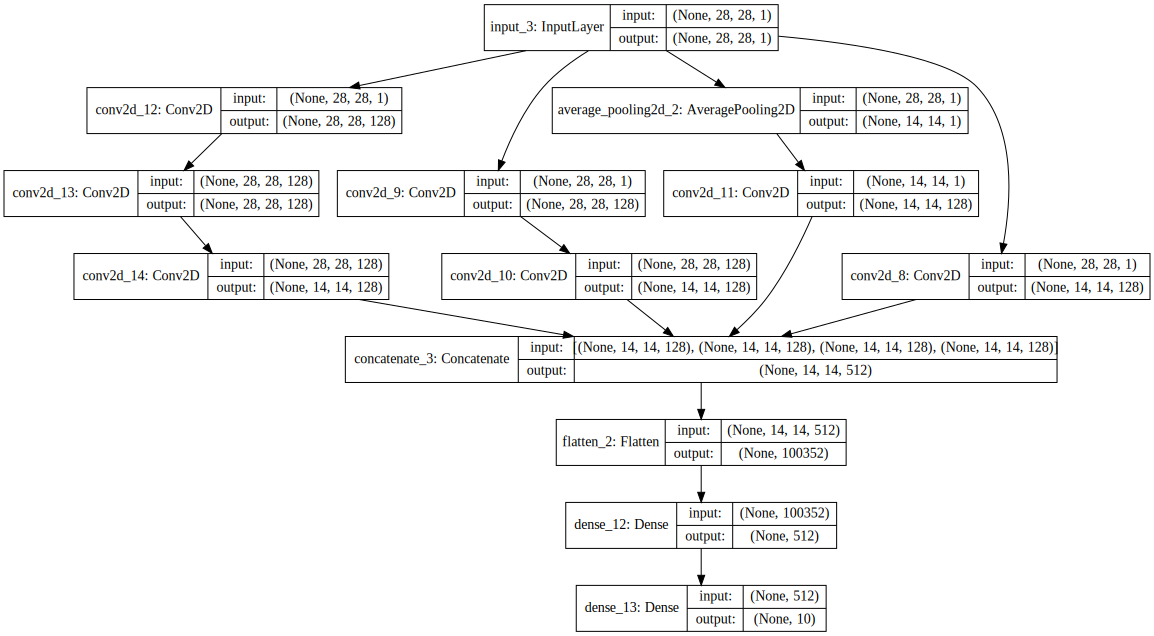

In [21]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

###### Реализация ResNET, когда размеры карты объектов отличаются

И следующее реализует остаточное соединение, когда размеры карты объектов различаются, используя линейное остаточное соединение (опять же, предполагая существование 4-мерного входного тензора х):

In [22]:
from keras import layers 
from keras.layers import Input

# Этот пример ожидаем 4д тензор
# Возвращаем тензор, который ожидаем для MNIST
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)


y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.MaxPooling2D(2, strides=2)(y)

# Используем свертку, чтобы совпадали карты объектов
residual = layers.Conv2D(128, 1, strides=2, padding='same')(x)

# загоняем все в сеточку
output = layers.add([y, residual])

# классификатор наверху
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)
model = keras.models.Model(inputs=x, outputs=predictions)

x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 128)  1280        images[0][0]                     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 128)  0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 

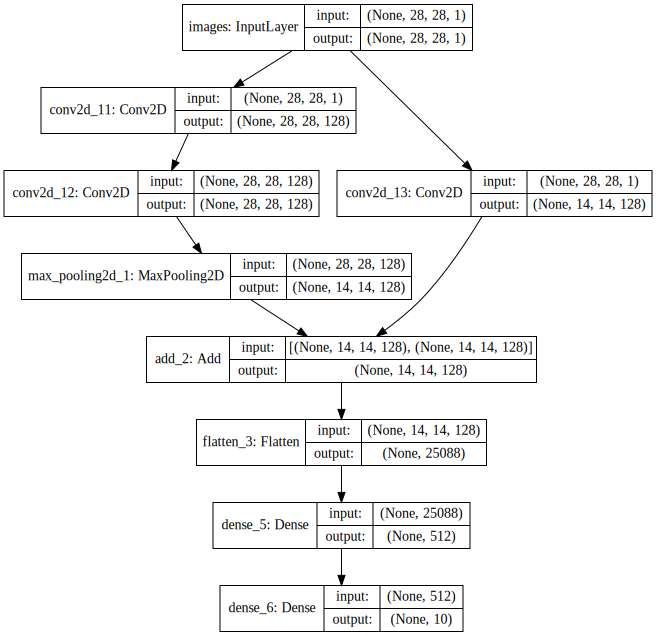

In [23]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

#### Обучаем  ResNET model на MNIST 
карта признаков одинаковая

In [24]:
import numpy as np
import os
import tempfile

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist

import tensorflow as tf

if K.backend() != 'tensorflow':
    raise RuntimeError('This example can only run with the TensorFlow backend,'
                       ' because it requires the Dataset API, which is not'
                       ' supported on other platforms.')

batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 5
num_classes = 10

def cnn_layers(x):

    print("x.shape:",x.shape)

    y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
    y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

    output = layers.add([y, x])


    output = layers.Flatten()(output)
    output = layers.Dense(512, activation='relu')(output)
    predictions = layers.Dense(10, activation='softmax')(output)
    return predictions

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_train = np.expand_dims(x_train, -1)
y_train = tf.one_hot(y_train, num_classes)


dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()


inputs, targets = iterator.get_next()

print("inputs.shape:",inputs.shape)
print("targets.shape:",targets.shape)

model_input = layers.Input(tensor=inputs)
model_output = cnn_layers(model_input)

model = keras.models.Model(inputs=model_input, outputs=model_output)

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              target_tensors=[targets])

inputs.shape: (?, 28, 28, 1)
targets.shape: (?, 10)
x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 128)  1280        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_15[0][0]                  
__________________________________________________________________________________________________
add_3 (Add

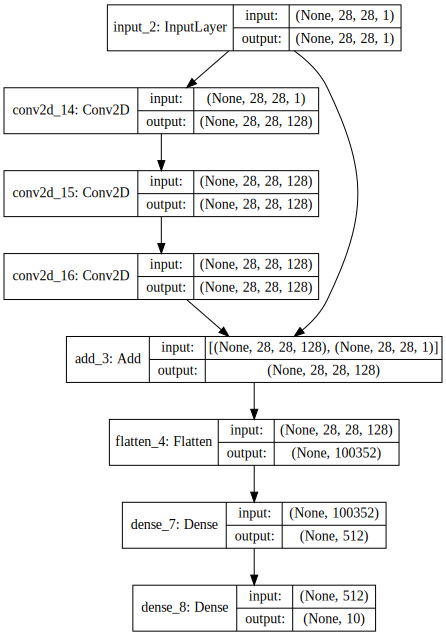

In [25]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

#### Учим и сохраняем ResNet model

In [26]:
model.fit(epochs=epochs,
          steps_per_epoch=steps_per_epoch)

# Сохраняем веса
weight_path = os.path.join(tempfile.gettempdir(), 'saved_ResNet_wt.h5')
model.save_weights(weight_path)

Epoch 1/5
469/469 [==============================] - 58s 124ms/step - loss: 11.3503 - acc: 0.2931 1:46 - loss: 12.5207 - ETA - ETA: 1: - ETA: 1:12 - lo
Epoch 2/5
469/469 [==============================] - 49s 103ms/step - loss: 10.5958 - acc: 0.3419
Epoch 3/5
469/469 [==============================] - 48s 103ms/step - loss: 10.4431 - acc: 0.3515 ETA: 33s - loss: 10.5102 - ac - ETA: 32s - l - ETA: 21s  - ETA
Epoch 4/5
469/469 [==============================] - 48s 103ms/step - loss: 10.4150 - acc: 0.3534 32s - loss: 10.4166 - acc: 0.3  - ETA:  - ETA: 20s - loss: 10 - ETA: 18s - loss: 10.4 - ETA: 12s - loss: 10.4267
Epoch 5/5
469/469 [==============================] - 48s 103ms/step - loss: 10.3513 - acc: 0.3574s - loss: 10.3539 - acc


#### Чекнем нашу модель

In [27]:
# Очищаем места для переменных
K.clear_session()


x_test = x_test.astype(np.float32)
x_test = np.expand_dims(x_test, -1)

x_test_inp = layers.Input(shape=x_test.shape[1:])
test_out = cnn_layers(x_test_inp)
test_model = keras.models.Model(inputs=x_test_inp, outputs=test_out)

weight_path = os.path.join(tempfile.gettempdir(), 'saved_ResNet_wt.h5')
test_model.load_weights(weight_path)
test_model.compile(optimizer='rmsprop',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
test_model.summary()

loss, acc = test_model.evaluate(x_test, y_test, num_classes)
print('\nTest accuracy: {0}'.format(acc))

x.shape: (?, 28, 28, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_2[0][0]                   
_____________________________________________________________________________________

### 7.1.6. Модели как слои

Важно отметить, что в функциональном API модели можно использовать по мере использования слоев - фактически вы можете думать о модели как о «большем слое». Это верно как для классов Sequential, так и для классов Model. Это означает, что вы можете вызвать модель для входного тензора и получить выходной тензор:

    у = модель (х)

Если модель имеет несколько входных тензоров и несколько выходных тензоров, ее следует вызывать со списком тензоров:

    y1, y2 = модель ([x1, x2])

Когда вы вызываете экземпляр модели, вы повторно используете вес модели - точно так же, как и при вызове экземпляра слоя. Вызов экземпляра, будь то экземпляр уровня или экземпляра модели, всегда будет повторно использовать существующие изученные представления экземпляра, что интуитивно понятно.

In [28]:
from keras import layers
from keras import applications 
from keras import Input

nbr_classes = 10

# Возьмем готовую модель Xception
xception_base = applications.Xception(weights=None,include_top=False)

# входная картинка  250 × 250 RGB.
left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

left_features = xception_base(left_input)
right_features = xception_base(right_input)

merged_features = layers.concatenate([left_features, right_features], axis=-1)

predictions = layers.Dense(nbr_classes, activation='softmax')(merged_features)

# Instantiating the model
model = Model([left_input, right_input], predictions)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
xception (Model)                multiple             20861480    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 8, 8, 4096)   0           xception[1][0]                   
          

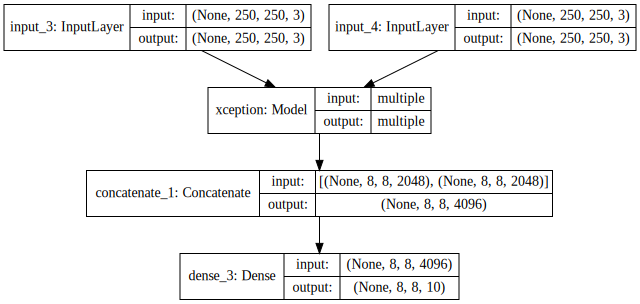

In [29]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Итого - давайте теперь соберем модель с двумя входами, где оба входа - обработчики картинок.
Выхода у нас тоже 2 - предположим мы решаем задачу следующего ввида - ищем как контент картинки, так и время года!